In [1]:
import cv2
import os
import numpy as np

In [2]:
def extract_frames_from_videos(video_dir, output_dir, frame_rate=5):
    """Extract frames from videos and save them into subdirectories based on the video category."""
    class_names = ['LegalBall','Wide']  # Define class labels

    for class_name in class_names:
        class_folder = os.path.join(video_dir, class_name)
        output_class_dir = os.path.join(output_dir, 'extracted_frames', class_name)
        os.makedirs(output_class_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        for video_file in os.listdir(class_folder):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_folder, video_file)
                video = cv2.VideoCapture(video_path)
                success, image = video.read()
                frame_count = 0
                while success:
                    if frame_count % frame_rate == 0:  # Capture frame at specific intervals
                        frame_filename = f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                        frame_output_path = os.path.join(output_class_dir, frame_filename)
                        image_resized = cv2.resize(image, (224, 224))  # Resize for CNN
                        cv2.imwrite(frame_output_path, image_resized)  # Save frame
                    success, image = video.read()
                    frame_count += 1

In [3]:
video_dir = 'Wide/'  # Path to your dataset directory 
output_dir = 'Wide/data/'  # Root directory where all data will be saved

In [4]:
extract_frames_from_videos(video_dir, output_dir)

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

In [6]:
def load_data_from_frames(output_dir):
    """Load frames from directories and prepare the data for training."""
    class_names = ['LegalBall','Wide']
    data = []
    labels = []

    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(output_dir, 'extracted_frames', class_name)
        for frame_file in os.listdir(class_folder):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(class_folder, frame_file)
                image = cv2.imread(frame_path)
                data.append(image)
                labels.append(class_id)  # Assign class label

    data = np.array(data)
    labels = np.array(labels)
    
    # Normalize the frames
    data = data.astype('float32') / 255.0
    
    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=4)

    return data, labels


In [7]:
# Load frames and labels
frames_data, labels_data = load_data_from_frames(output_dir)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(frames_data, labels_data, test_size=0.2, random_state=42)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define the model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN part wrapped in TimeDistributed (to apply the CNN to each frame)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    # LSTM part
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer (4 classes: No Ball, Legal Ball, Wide, LBW)
    model.add(Dense(4, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Define the input shape: (10 frames, 224x224 pixels, 3 color channels)
input_shape = (10, 224, 224, 3)
model = create_cnn_lstm_model(input_shape)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 222, 222, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 222, 222, 32)    │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 111, 111, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 109, 109, 64)    │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 109, 109, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 54, 54, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 52, 52, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 52, 52, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 26, 26, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 86528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │      22,167,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,270,788 (84.96 MB)

 Trainable params: 22,270,340 (84.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Data augmentation (to reduce overfitting and introduce more data variety)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [14]:
# Apply augmentation frame by frame before creating sequences
def augment_frames(X_train):
    augmented_frames = []
    for frame in X_train:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return np.array(augmented_frames)


In [15]:
# Function to create frame sequences for the model
def create_frame_sequences(data, labels, sequence_length=10):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(data) - sequence_length, sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Use the label of the last frame in the sequence
    
    return np.array(sequences), np.array(sequence_labels)

In [16]:
# Example data (X_train, y_train) should be processed with your dataset
# Assuming X_train and y_train are preprocessed
# Manually augment data frame by frame
X_train_augmented = augment_frames(X_train)

In [17]:
# Group the frames into sequences of 10 frames each
X_train_seq, y_train_seq = create_frame_sequences(X_train_augmented, y_train, sequence_length=10)
X_test_seq, y_test_seq = create_frame_sequences(X_test, y_test, sequence_length=10)

In [18]:
# Define learning rate scheduler and checkpoint
checkpoint = ModelCheckpoint('wide_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [19]:
# Train the model using the sequences of frames
history = model.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=4,
                    validation_data=(X_test_seq, y_test_seq),
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3856 - loss: 1.3138
Epoch 1: val_loss improved from inf to 0.77877, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 247s 6s/step - accuracy: 0.3886 - loss: 1.3093 - val_accuracy: 0.6098 - val_loss: 0.7788 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8268 - loss: 0.6590
Epoch 2: val_loss improved from 0.77877 to 0.49415, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.8255 - loss: 0.6606 - val_accuracy: 0.8537 - val_loss: 0.4941 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6817 - loss: 0.7678
Epoch 3: val_loss improved from 0.49415 to 0.42375, saving model to wide_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.6827 - loss: 0.7661 - val_accuracy: 0.9512 - val_loss: 0.4238 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7506 

In [20]:
import pandas as pd

In [21]:
# Create the logs directory
logs_dir = os.path.join(output_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [22]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

In [23]:
# Save the training history to CSV
log_file_path = os.path.join(logs_dir, 'training_log.csv')
history_df.to_csv(log_file_path, index=False)

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

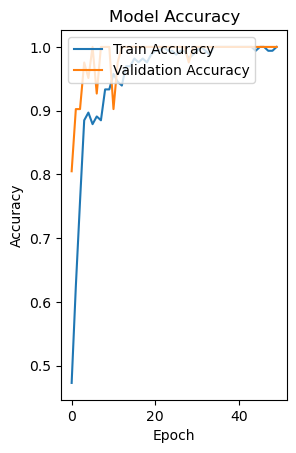

In [26]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

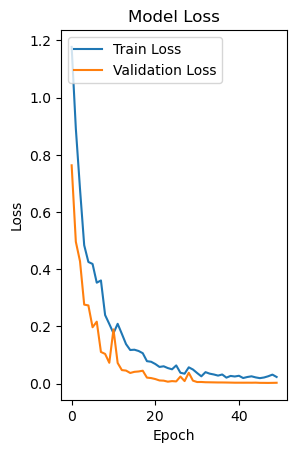

In [27]:
# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf

In [3]:
# Assuming your model has been saved as 'wide_model.keras'
model = load_model('wide_model.keras')

In [4]:
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame to the size expected by the model (frame_size)
        frame_resized = cv2.resize(frame, frame_size)
        
        # Optionally normalize the frame (if required by the model)
        frame_normalized = frame_resized / 255.0  # Example for normalization
        
        frames.append(frame_normalized)

        # Skip frames to match the desired frame rate (if needed)
        # if frame_count % frame_rate == 0:
        #     frames.append(frame_normalized)
    
    cap.release()
    
    # Convert the list of frames to a numpy array
    frames = np.array(frames)

    # Make sure the shape of the frames matches the input shape of the model
    return frames

In [5]:
def predict_ball_type(video_path, threshold=0.7):
    """
    Predicts whether the ball is a 'wide ball' or 'legal ball' from the given video.
    """
    frames = preprocess_video(video_path)
    
    if frames.shape[0] == 0:
        return "Cannot identify: No frames detected."
    
    # Reshaping the input frames to match the model's input shape
    # This assumes your model expects a batch of frames with shape (batch_size, height, width, channels)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension (1, frame_count, height, width, channels)
    
    # Perform prediction on the frames
    predictions = model.predict(frames)
    
    # If you have binary classification or two classes
    class_probabilities = predictions[0]  # Assuming this is a softmax output
    class_labels = ['Legal Ball', 'Wide Ball']
    
    # Find the predicted class and probability
    predicted_class = np.argmax(class_probabilities)
    predicted_probability = class_probabilities[predicted_class]
    
    # Check if the predicted probability is above the threshold
    if predicted_probability >= threshold:
        return f"Prediction: {class_labels[predicted_class]} with probability {predicted_probability:.2f}"
    else:
        return "Cannot identify: Confidence too low."

In [11]:
video_path = 'legalballs14 _mirr.mp4'
prediction = predict_ball_type(video_path)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Legal Ball with probability 0.99


# Evaluation

## recall_score, precision_score, f1_score, accuracy_score

In [7]:
import os
import numpy as np
import cv2
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('wide_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    """
    Preprocess the input video to extract frames and resize them for the model.
    If the video has fewer frames than `sequence_length`, pad with zeros (empty frames).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize the frame
        frames.append(frame_normalized)
    
    cap.release()

    # Check if no frames were read
    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))  # Return a placeholder of zeros
    
    # If there are fewer frames than required, pad with empty frames (zeros)
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    # If there are more frames, truncate to the required sequence length
    frames = frames[:sequence_length]

    # Convert the frames list to a numpy array with shape (sequence_length, height, width, channels)
    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    """
    Evaluate the model on a dataset and compute the classification metrics.
    """
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    
    # Keep track of the count of classes to calculate the class weight
    class_count = {'Wide': 0, 'LegalBall': 0}
    
    # Walk through the dataset, which has a 'NoBall' folder containing subfolders 'Wide' and 'LegalBall'
    for class_name in ['Wide', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        # Skip if the class folder is empty or does not exist
        if not os.path.isdir(class_folder):
            print(f"Warning: Folder {class_folder} not found.")
            continue
        
        # Process videos in each class folder
        for video_name in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_name)
            
            # Preprocess the video to get the sequence of frames
            video_frames = preprocess_video(video_path, sequence_length=sequence_length)
            
            # Make prediction
            prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension
            predicted_label = np.argmax(prediction[0])  # Find the predicted class label (max probability)
            
            # Ground truth based on the folder name
            ground_truth = 1 if class_name == "Wide" else 0  # 1 for WideBall, 0 for LegalBall
            
            # Append true and predicted labels
            y_true.append(ground_truth)
            y_pred.append(predicted_label)
            
            # Count class instances for weighting
            class_count[class_name] += 1
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle ZeroDivisionError by checking if a class has zero samples
    total_samples = sum(class_count.values())
    
    if class_count['LegalBall'] == 0 or class_count['Wide'] == 0:
        print("Warning: One of the classes has zero samples. Skipping class weight calculation.")
        class_weights = {0: 1, 1: 1}  # Default weights if any class is missing
    else:
        class_weights = {
            0: total_samples / (2 * class_count['LegalBall']),  # Weight for class 'LegalBall'
            1: total_samples / (2 * class_count['Wide'])   # Weight for class 'WideBall'
        }

    # Calculate the metrics with class weights (use the 'balanced' option for the average argument)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Return the metrics
    return accuracy, precision, recall, f1

# Path to your dataset
dataset_path = 'Wide'  # Update this path to point to the 'NoBall' folder containing 'Wide' and 'LegalBall'

# Evaluate the model and print the metrics
accuracy, precision, recall, f1 = evaluate_model(dataset_path, sequence_length=10)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## ROC Curve and AUC

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

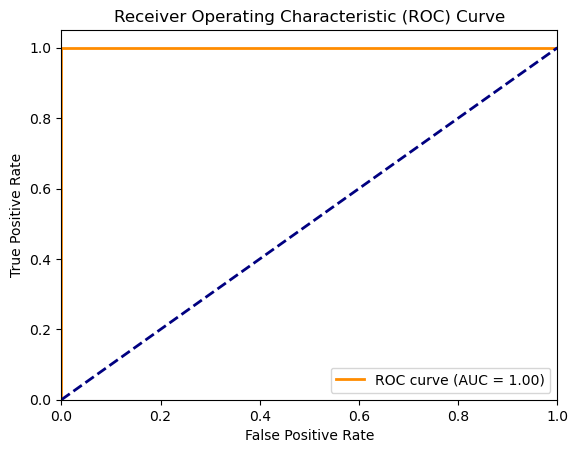

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0


In [8]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_curve, auc
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('wide_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)
    
    cap.release()

    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))
    
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    frames = frames[:sequence_length]

    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    y_prob = []  # Predicted probabilities (for ROC curve)
    
    class_count = {'Wide': 0, 'LegalBall': 0}
    
    for class_name in ['Wide', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_folder):
            print(f"Warning: Folder {class_folder} not found.")
            continue
        
        for video_name in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_name)
            
            video_frames = preprocess_video(video_path, sequence_length=sequence_length)
            
            prediction = model.predict(np.expand_dims(video_frames, axis=0))
            predicted_label = np.argmax(prediction[0])
            
            ground_truth = 1 if class_name == "Wide" else 0
            
            y_true.append(ground_truth)
            y_pred.append(predicted_label)
            y_prob.append(prediction[0][1])  # Get the probability of the positive class (Wide)
            
            class_count[class_name] += 1
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    total_samples = sum(class_count.values())
    
    if class_count['LegalBall'] == 0 or class_count['Wide'] == 0:
        print("Warning: One of the classes has zero samples. Skipping class weight calculation.")
        class_weights = {0: 1, 1: 1}
    else:
        class_weights = {
            0: total_samples / (2 * class_count['LegalBall']),
            1: total_samples / (2 * class_count['Wide'])
        }

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

# Path to your dataset
dataset_path = 'Wide'  # Update this path to point to the 'NoBall' folder containing 'Wide' and 'LegalBall'

# Evaluate the model and print the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(dataset_path, sequence_length=10)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

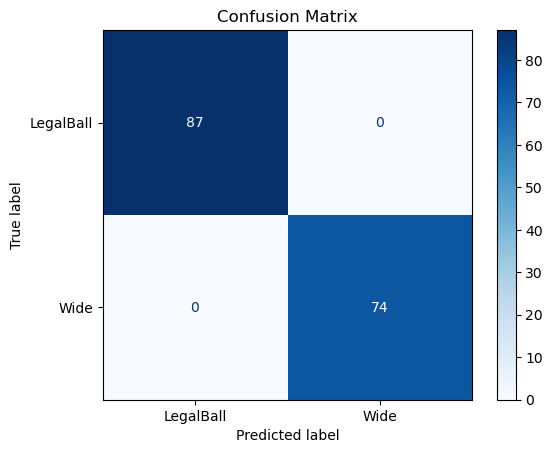

Confusion Matrix:
[[87  0]
 [ 0 74]]


In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('wide_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)
    
    cap.release()

    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))
    
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    frames = frames[:sequence_length]

    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    
    for class_name in ['Wide', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_folder):
            print(f"Warning: Folder {class_folder} not found.")
            continue
        
        for video_name in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_name)
            
            video_frames = preprocess_video(video_path, sequence_length=sequence_length)
            
            prediction = model.predict(np.expand_dims(video_frames, axis=0))
            predicted_label = np.argmax(prediction[0])
            
            ground_truth = 1 if class_name == "Wide" else 0
            
            y_true.append(ground_truth)
            y_pred.append(predicted_label)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LegalBall', 'Wide'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

# Path to your dataset
dataset_path = 'Wide'  # Update this path to point to the 'NoBall' folder containing 'Wide' and 'LegalBall'

# Evaluate the model and print the confusion matrix
cm = evaluate_model(dataset_path, sequence_length=10)
print(f"Confusion Matrix:\n{cm}")


## Matthews Correlation Coefficient (MCC)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

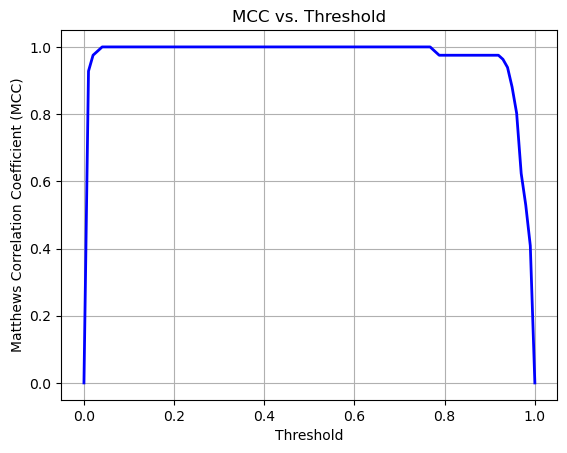

In [10]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('wide_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)
    
    cap.release()

    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))
    
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    frames = frames[:sequence_length]

    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    y_prob = []  # Predicted probabilities (for MCC with thresholds)
    
    for class_name in ['Wide', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_folder):
            print(f"Warning: Folder {class_folder} not found.")
            continue
        
        for video_name in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_name)
            
            video_frames = preprocess_video(video_path, sequence_length=sequence_length)
            
            prediction = model.predict(np.expand_dims(video_frames, axis=0))
            predicted_label = np.argmax(prediction[0])
            predicted_prob = prediction[0][1]  # Get the probability for the "Wide" class
            
            ground_truth = 1 if class_name == "Wide" else 0
            
            y_true.append(ground_truth)
            y_pred.append(predicted_label)
            y_prob.append(predicted_prob)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    mcc_values = []

    # Calculate MCC for each threshold
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred_thresholded)
        mcc_values.append(mcc)

    # Plot MCC curve
    plt.plot(thresholds, mcc_values, color='blue', lw=2)
    plt.xlabel('Threshold')
    plt.ylabel('Matthews Correlation Coefficient (MCC)')
    plt.title('MCC vs. Threshold')
    plt.grid(True)
    plt.show()

    return mcc_values, thresholds

# Path to your dataset
dataset_path = 'Wide'  # Update this path to point to the 'NoBall' folder containing 'Wide' and 'LegalBall'

# Evaluate the model and plot the MCC curve
mcc_values, thresholds = evaluate_model(dataset_path, sequence_length=10)
